In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First we will import the libraries needed.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense,Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow import keras

2024-02-22 01:03:16.901195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 01:03:16.901317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 01:03:17.046608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Now we will read the dataset using a tf.data.Dataset object.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
dataset = tf.data.Dataset.list_files('/kaggle/input/gan-getting-started/monet_jpg/*')
dataset

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

Now we will reads the file content as bytes, decodes it as a JPEG image using TensorFlow, and then converts the image to grayscale using the rgb_to_grayscale function.

In [4]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    img = tf.image.rgb_to_grayscale(img)
    return img

In [5]:
dataset = dataset.map(load_image)

Visuallizing the data:

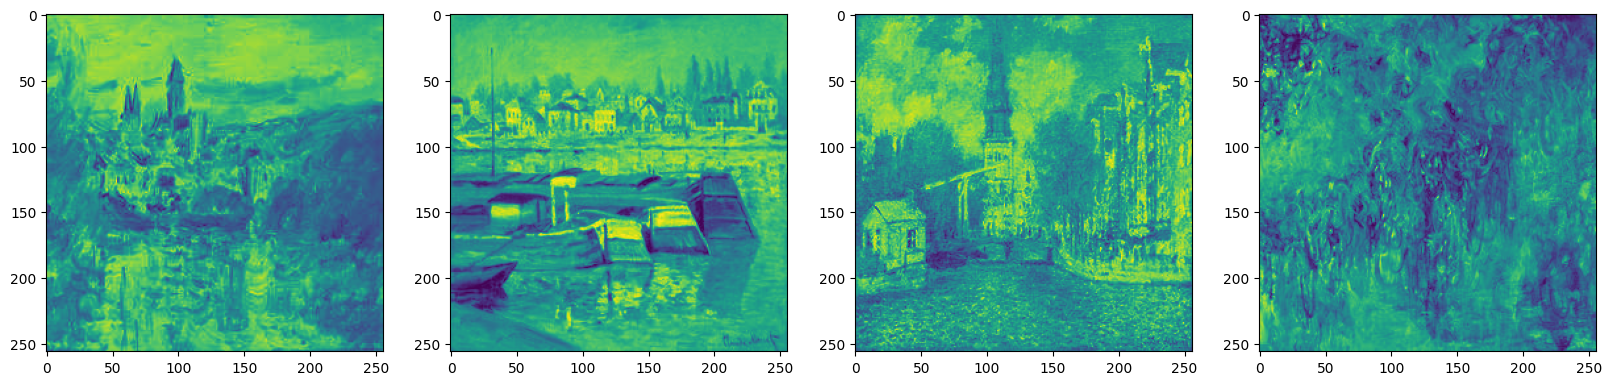

In [6]:
image_gen = dataset.batch(4).as_numpy_iterator()
plot_img = image_gen.next()
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx,imag in enumerate(plot_img):
    ax[idx].imshow(np.squeeze(imag))
plt.show()

In [7]:
def scale_image(image):
 
    return image / 255

The next step is to perform data transformation and create batches of images for training the GANs

In [8]:
dataset = dataset.map(scale_image)
dataset = dataset.cache()
dataset = dataset.shuffle(301)
dataset = dataset.batch(16)
dataset = dataset.prefetch(64)


In [9]:
dataset.as_numpy_iterator().next().shape

(16, 256, 256, 1)

Now we will build the generator

In [10]:
def build_gen():
    seq_model = Sequential()
    
    # Input layer take in random values and reshape it into 16, 16, 128
    seq_model.add(Dense(16*16*128,input_dim = 16))
    seq_model.add(LeakyReLU(0.2))
    seq_model.add(Reshape((16,16,128)))
    
    
    # Upsampling layer 1 that will make it 32,32 128
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    # Upsampling layer 2
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    # Upsampling layer 3
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    # Upsampling layer 4
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))

    
    # Convolutional layer one 
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    # Convolutional layer two for a better pattern detection
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    
    # Convolutional layer to get to one channel
    seq_model.add(Conv2D(1,4,padding="same", activation="sigmoid"))
    return seq_model

In [11]:
model = build_gen()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             557056    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                        

In [12]:
image = model.predict(np.random.randn(2,16,1))
image

1/1 [==============================] - 2s 2s/step


array([[[[0.49961865],
         [0.49971473],
         [0.49964947],
         ...,
         [0.49979368],
         [0.49978828],
         [0.4999541 ]],

        [[0.49991748],
         [0.50013375],
         [0.4999073 ],
         ...,
         [0.4996513 ],
         [0.4996587 ],
         [0.4998379 ]],

        [[0.49969146],
         [0.5001102 ],
         [0.4998249 ],
         ...,
         [0.49960685],
         [0.4997032 ],
         [0.4998298 ]],

        ...,

        [[0.50008196],
         [0.50014114],
         [0.500147  ],
         ...,
         [0.50000376],
         [0.5000101 ],
         [0.5000204 ]],

        [[0.4999782 ],
         [0.49999806],
         [0.49992114],
         ...,
         [0.50001246],
         [0.5000488 ],
         [0.5000341 ]],

        [[0.5000878 ],
         [0.5000538 ],
         [0.5000175 ],
         ...,
         [0.5000708 ],
         [0.50007045],
         [0.50006217]]],


       [[[0.49944803],
         [0.4997174 ],
         [0.49

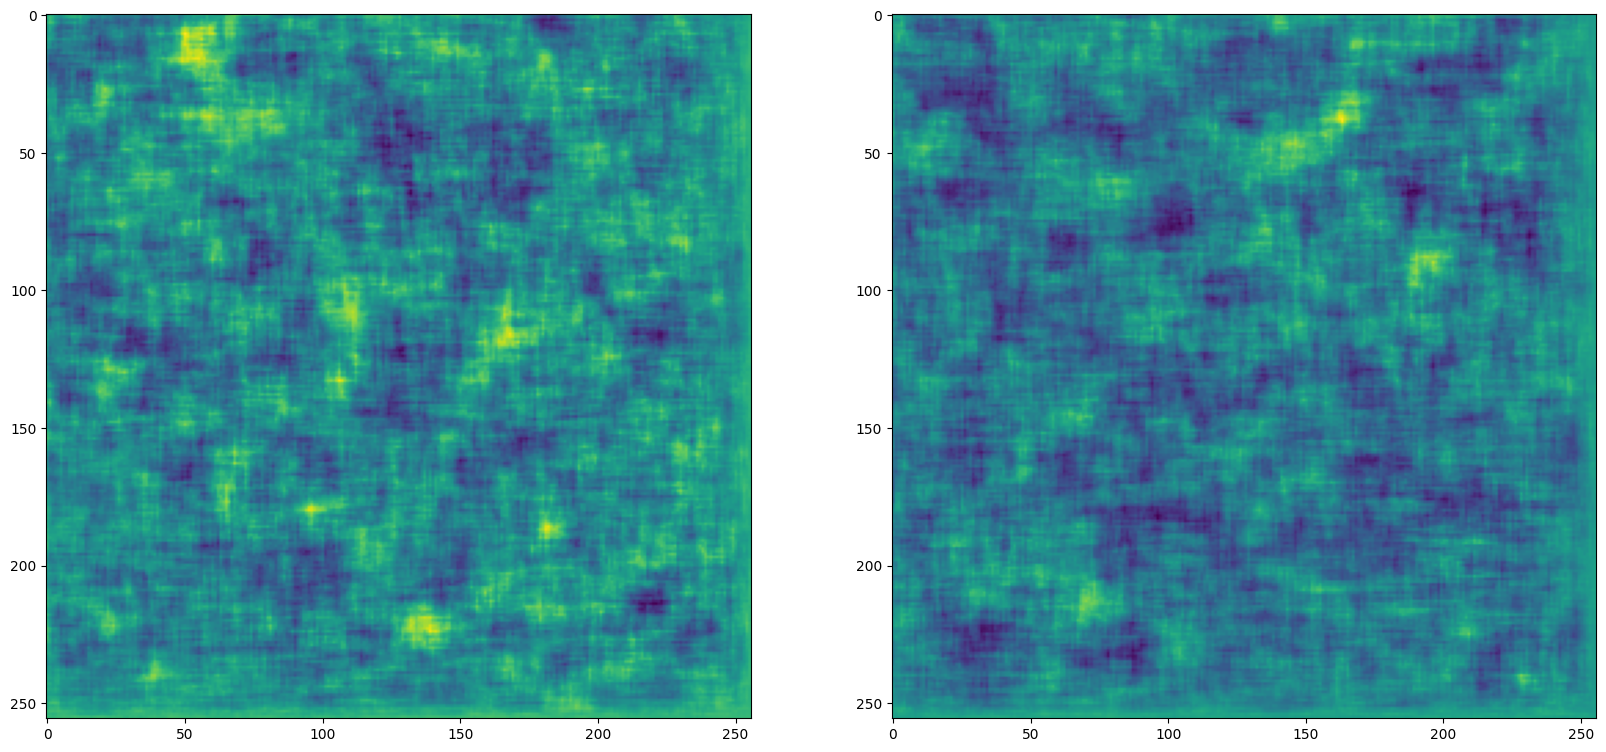

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,20))

for idx,im in enumerate(image):
    ax[idx].imshow(np.squeeze(im))

    

Now we will build the discrimenator

In [14]:
def build_disc():
    model = Sequential()
    
    # Convenotional layer 1 for pattern detection
    model.add(Conv2D(32, 5, input_shape = (256,256,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Convenotional layer 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Convenotional layer 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #  Convenotional layer 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    
    # Flatten the output
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:
disc = build_disc()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      832       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 252, 252, 32)      0         
                                                                 
 dropout (Dropout)           (None, 252, 252, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 248, 248, 64)      51264     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 248, 248, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 248, 248, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 244, 244, 128)    

In [16]:
plot_img.shape
image.shape

(2, 256, 256, 1)

In [17]:
## test the discriminator

disc.predict(image)

1/1 [==============================] - 2s 2s/step


array([[0.49519965],
       [0.49519303]], dtype=float32)

In [18]:
gen_opt = Adam(learning_rate=0.0001)
disc_opt = Adam(learning_rate=0.00001)
gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

Now we will train the model

In [19]:
def train(real, gen_opt, disc_opt, gen_loss, disc_loss):
    gen = build_gen()
    disc = build_disc()
    
    
    for epoch in range(20):
        fake = gen(tf.random.normal((16, 16, 1)), training = False)
        image = real.as_numpy_iterator().next()
        with tf.GradientTape() as dtape:
            # Get the discriminator's predictions for real and fake images
            real_logits = disc(image, training = True)
            fake_logits = disc(fake, training = True)
            
            realfake_logits = tf.concat([real_logits, fake_logits], axis=0)
            
            # Create labels for real and fakes images
            logit_realfake = tf.concat([tf.zeros_like(real_logits), tf.ones_like(fake_logits)], axis=0)
            
            # Add some noise to the TRUE outputs to avoid overfitting
            noise_real = 0.15*tf.random.uniform(tf.shape(real_logits))
            noise_fake = -0.15*tf.random.uniform(tf.shape(fake_logits))
            logit_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss  
            total_d_loss = disc_loss(logit_realfake, realfake_logits)
           
        # Update the generator's weights and biases
        dgradients = dtape.gradient(total_d_loss, disc.trainable_variables)
        disc_opt.apply_gradients(zip(dgradients, disc.trainable_variables))
            
        with tf.GradientTape() as gtape:

            fake = gen(tf.random.normal((16, 16, 1)), training = True)
            # Get the discriminator's predictions for fake images
            fake_logits = disc(fake, training = False)

            # Calculate the generator's loss
            g_loss = gen_loss(tf.zeros_like(fake_logits), fake_logits)

        # Update the generator's weights and biases
        gen_gradients = gtape.gradient(g_loss, gen.trainable_variables)
        gen_opt.apply_gradients(zip(gen_gradients, gen.trainable_variables))

In [20]:
train(dataset,gen_opt, disc_opt, gen_loss, disc_loss)

1/1 [==============================] - 15s 15s/step


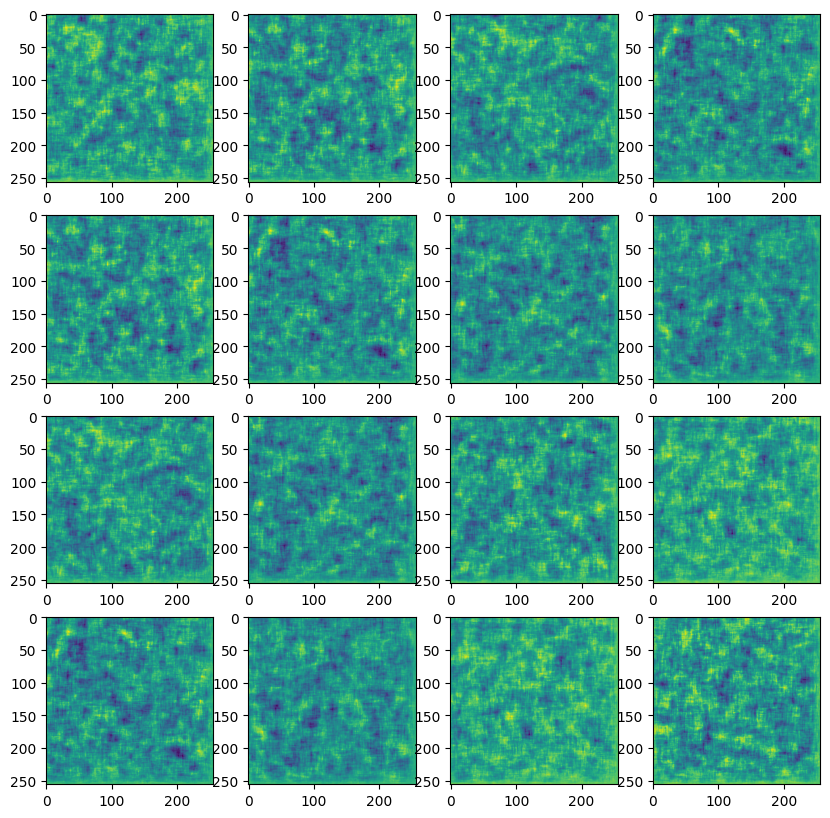

In [21]:
discriminator = build_disc()
generator = build_gen()
imgs = generator.predict(tf.random.normal((16, 16, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [22]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
